# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6428544436383202619
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15517027048447507432
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 17:18:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'VGG16'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 5
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4"
T_all_labels = "T0", "T1", "T2", "T3", "T4"

#base_path = ''
base_path = 'gdrive/My Drive/Research_5_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_VGG16_None S_VGG16_imagenet T_VGG16_None T_VGG16_imagenet


['S_VGG16_imagenet', 'S_VGG16_None', 'T_VGG16_imagenet', 'T_VGG16_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2034, 128, 128, 3) (2034, 1)
(678, 128, 128, 3) (678, 1)
(678, 128, 128, 3) (678, 1)

(2274, 128, 128, 3) (2274, 1)
(758, 128, 128, 3) (758, 1)
(758, 128, 128, 3) (758, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2034, 128, 128, 3) (2034, 5)
(678, 128, 128, 3) (678, 5)
(678, 128, 128, 3) (678, 5)

(2274, 128, 128, 3) (2274, 5)
(758, 128, 128, 3) (758, 5)
(758, 128, 128, 3) (758, 5)


## 2-2. Image Check

xTrain_S image Numbers :  2034
xTrain_S image Numbers // 10 :  203
11


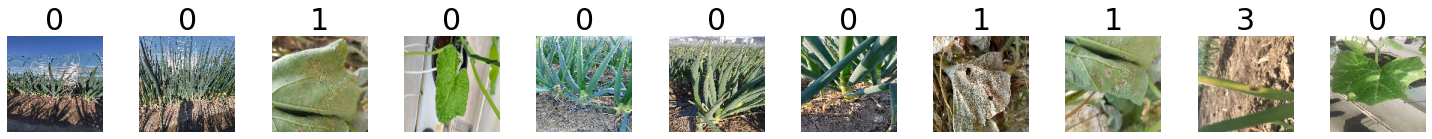

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2274
xTrain_S image Numbers // 10 :  227
11


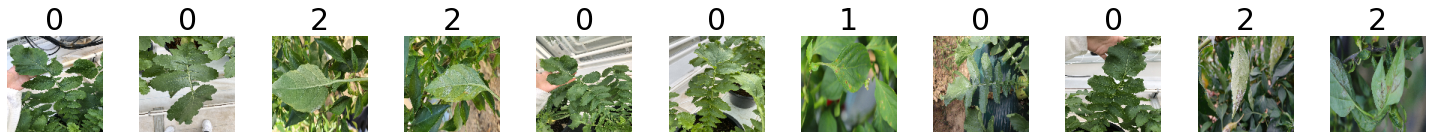

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.VGG16 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.VGG16 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 22s 285ms/step - loss: 4.9777 - accuracy: 0.4243 - val_loss: 1.4152 - val_accuracy: 0.4425
Epoch 2/100
32/32 [==============================] - 5s 145ms/step - loss: 1.4402 - accuracy: 0.4425 - val_loss: 1.4300 - val_accuracy: 0.4425
Epoch 3/100
32/32 [==============================] - 5s 145ms/step - loss: 1.4296 - accuracy: 0.4425 - val_loss: 1.4288 - val_accuracy: 0.4425
Epoch 4/100
32/32 [==============================] - 5s 145ms/step - loss: 1.4257 - accuracy: 0.4425 - val_loss: 1.4273 - val_accuracy: 0.4425
Epoch 5/100
32/32 [==============================] - 5s 145ms/step - loss: 1.4280 - accuracy: 0.4425 - val_loss: 1.4259 - val_accuracy: 0.4425
Epoch 6/100
32/32 [==============================] - 5s 145ms/step - loss: 1.4276 - accuracy: 0.4425 - val_loss: 1.4268 - val_accuracy: 0.4425
Epoch 7/100
32/32 [==============================] - 5s 145ms/step - loss: 1.4291 - accuracy: 0.4425 - val_loss: 1.4284 - val_accuracy: 0.442

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,4.977696,0.424287,1.415199,0.442478
1,1.440188,0.442478,1.430017,0.442478
2,1.429644,0.442478,1.428833,0.442478
3,1.425744,0.442478,1.427280,0.442478
4,1.428035,0.442478,1.425896,0.442478
5,1.427636,0.442478,1.426795,0.442478
6,1.429062,0.442478,1.428445,0.442478
7,1.429764,0.442478,1.425536,0.442478
8,1.426772,0.442478,1.427301,0.442478
9,1.426724,0.442478,1.425264,0.442478


Minimum validation loss: 1.4151991605758667
Maximum validation accuracy: 0.44247788190841675


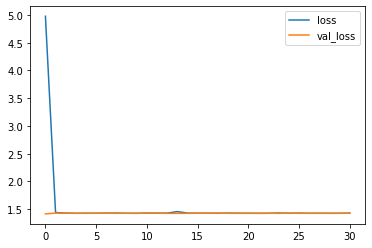

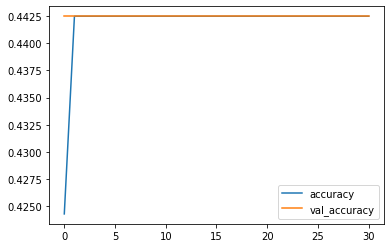

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
22/22 [==============================] - 2s 38ms/step - loss: 1.4167 - accuracy: 0.4425
test loss, test acc: [1.4166604280471802, 0.44247788190841675]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

22/22 [==============================] - 1s 20ms/step


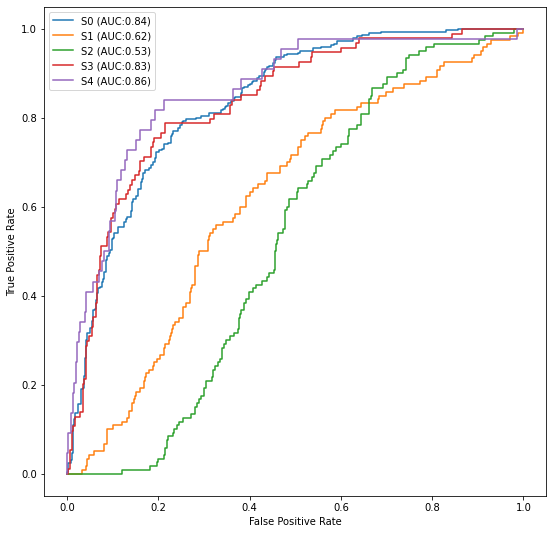

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

58900480/58889256 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 6s 161ms/step - loss: 3.0174 - accuracy: 0.4036 - val_loss: 1.4563 - val_accuracy: 0.4425
Epoch 2/100
32/32 [==============================] - 5s 147ms/step - loss: 1.3779 - accuracy: 0.4440 - val_loss: 1.2855 - val_accuracy: 0.4720
Epoch 3/100
32/32 [==============================] - 5s 147ms/step - loss: 1.1838 - accuracy: 0.5231 - val_loss: 1.3199 - val_accuracy: 0.5177
Epoch 4/100
32/32 [==============================] - 5s 147ms/step - loss: 1.0846 - accuracy: 0.5737 - val_loss: 1.0668 - val_accuracy: 0.5693
Epoch 5/100
32/32 [==============================] - 5s 147ms/step - loss: 1.0597 - accuracy: 0.5762 - val_loss: 0.9676 - val_accuracy: 0.6549
Epoch 6/100
32/32 [==============================] - 5s 146ms/step - loss: 0.9676 - accuracy: 0.6313 - val_loss: 0.9986 - val_accuracy: 0.6372
Epoch 7/100
32/32 [==============================] - 5s 147ms/step - loss: 0.8715 - accuracy: 0.6686 - val_loss: 0.8811 - val_accuracy: 0.6696

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,3.017449,0.403638,1.456327,0.442478
1,1.377863,0.443953,1.285549,0.471976
2,1.183779,0.523107,1.319939,0.517699
3,1.084556,0.573746,1.066780,0.569322
4,1.059732,0.576205,0.967555,0.654867
...,...,...,...,...
78,0.002210,0.999017,0.486511,0.929204
79,0.020829,0.993609,0.493764,0.912979
80,0.034636,0.992625,0.376337,0.915929
81,0.034694,0.989184,0.388697,0.926254


Minimum validation loss: 0.16133105754852295
Maximum validation accuracy: 0.9483776092529297


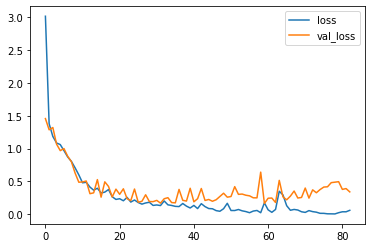

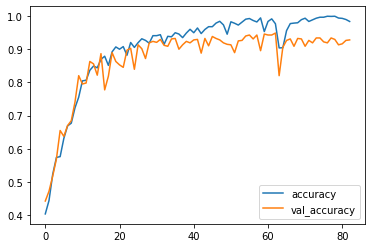

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
22/22 [==============================] - 1s 23ms/step - loss: 0.2398 - accuracy: 0.9277
test loss, test acc: [0.23981334269046783, 0.9277285933494568]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

22/22 [==============================] - 1s 20ms/step


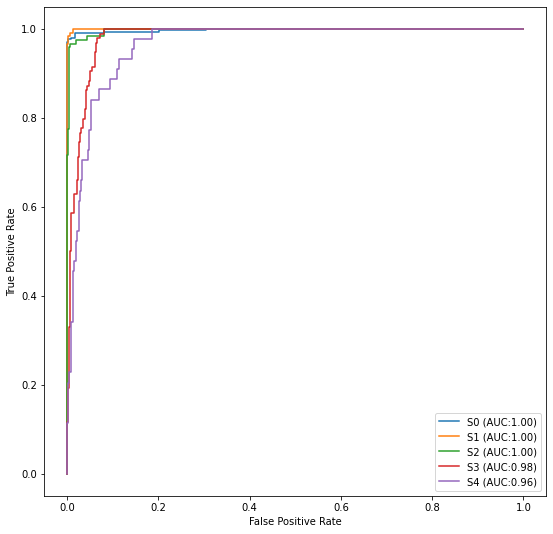

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 11s 267ms/step - loss: 1.5792 - accuracy: 0.3883 - val_loss: 1.4639 - val_accuracy: 0.3958
Epoch 2/100
36/36 [==============================] - 5s 145ms/step - loss: 1.4603 - accuracy: 0.3958 - val_loss: 1.4552 - val_accuracy: 0.3958
Epoch 3/100
36/36 [==============================] - 5s 144ms/step - loss: 1.4523 - accuracy: 0.3958 - val_loss: 1.4485 - val_accuracy: 0.3958
Epoch 4/100
36/36 [==============================] - 5s 144ms/step - loss: 1.4518 - accuracy: 0.3958 - val_loss: 1.4499 - val_accuracy: 0.3958
Epoch 5/100
36/36 [==============================] - 5s 145ms/step - loss: 1.4527 - accuracy: 0.3958 - val_loss: 1.4482 - val_accuracy: 0.3958
Epoch 6/100
36/36 [==============================] - 5s 144ms/step - loss: 1.4512 - accuracy: 0.3958 - val_loss: 1.4512 - val_accuracy: 0.3958
Epoch 7/100
36/36 [==============================] - 5s 144ms/step - loss: 1.4531 - accuracy: 0.3958 - val_loss: 1.4498 - val_accuracy: 0.395

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.579150,0.388303,1.463875,0.395778
1,1.460250,0.395778,1.455205,0.395778
2,1.452346,0.395778,1.448450,0.395778
3,1.451828,0.395778,1.449948,0.395778
4,1.452718,0.395778,1.448245,0.395778
5,1.451169,0.395778,1.451156,0.395778
6,1.453146,0.395778,1.449770,0.395778
7,1.449840,0.395778,1.457035,0.395778
8,1.450864,0.395778,1.449273,0.395778
9,1.448996,0.395778,1.450486,0.395778


Minimum validation loss: 1.4477200508117676
Maximum validation accuracy: 0.3957783579826355


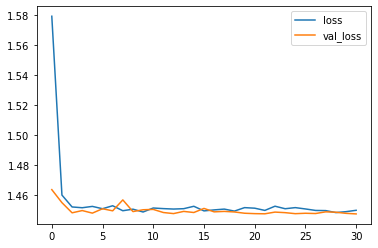

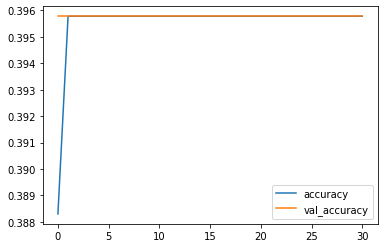

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
24/24 [==============================] - 1s 59ms/step - loss: 1.4639 - accuracy: 0.3958
test loss, test acc: [1.4638762474060059, 0.3957783579826355]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

24/24 [==============================] - 1s 20ms/step


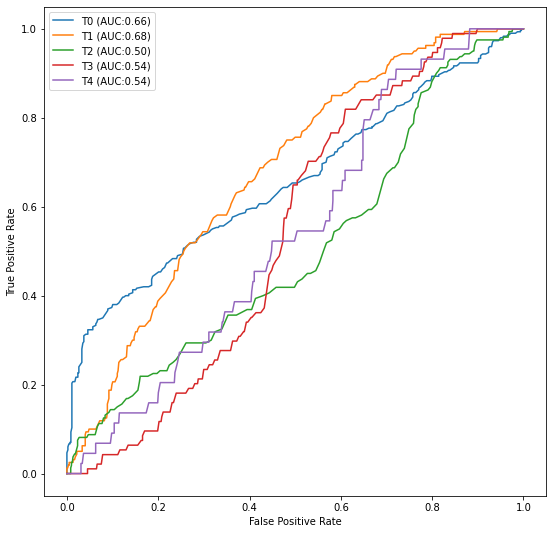

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 7s 156ms/step - loss: 1.6531 - accuracy: 0.3540 - val_loss: 1.4182 - val_accuracy: 0.3958
Epoch 2/100
36/36 [==============================] - 5s 145ms/step - loss: 1.3545 - accuracy: 0.4037 - val_loss: 1.2944 - val_accuracy: 0.4314
Epoch 3/100
36/36 [==============================] - 5s 146ms/step - loss: 1.4552 - accuracy: 0.3720 - val_loss: 1.3915 - val_accuracy: 0.4617
Epoch 4/100
36/36 [==============================] - 5s 146ms/step - loss: 1.2946 - accuracy: 0.4543 - val_loss: 1.1806 - val_accuracy: 0.4644
Epoch 5/100
36/36 [==============================] - 5s 146ms/step - loss: 1.2202 - accuracy: 0.4626 - val_loss: 1.1911 - val_accuracy: 0.4960
Epoch 6/100
36/36 [==============================] - 5s 144ms/step - loss: 1.1836 - accuracy: 0.4872 - val_loss: 1.2534 - val_accuracy: 0.4393
Epoch 7/100
36/36 [==============================] - 5s 144ms/step - loss: 1.2116 - accuracy: 0.4600 - val_loss: 1.2170 - val_accuracy: 0.4169

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,1.653056,0.354002,1.418212,0.395778
1,1.354486,0.403694,1.294385,0.431398
2,1.455152,0.372032,1.391504,0.461741
3,1.294648,0.454266,1.180629,0.464380
4,1.220192,0.462621,1.191126,0.496042
...,...,...,...,...
57,0.097456,0.970536,0.565943,0.852243
58,0.098004,0.967018,0.632863,0.841689
59,0.076915,0.974055,0.573932,0.849604
60,0.056669,0.979332,0.773459,0.833773


Minimum validation loss: 0.39987894892692566
Maximum validation accuracy: 0.8614775538444519


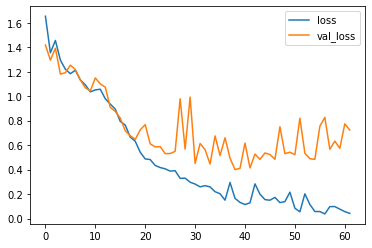

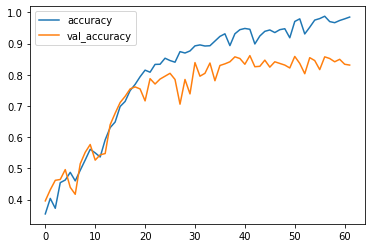

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
24/24 [==============================] - 1s 23ms/step - loss: 0.4365 - accuracy: 0.8747
test loss, test acc: [0.4365353584289551, 0.8746702075004578]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

24/24 [==============================] - 1s 20ms/step


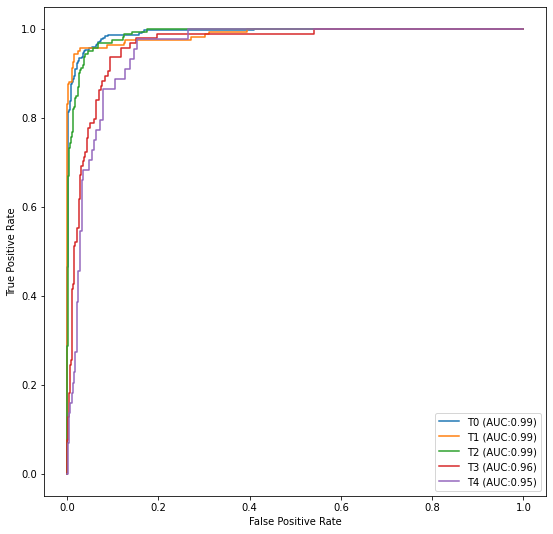

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_VGG16_None
test loss, test acc: [1.4166604280471802, 0.44247788190841675]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_VGG16_imagenet
test loss, test acc: [0.23981334269046783, 0.9277285933494568]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_VGG16_None
test loss, test acc: [1.4638762474060059, 0.3957783579826355]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_VGG16_imagenet
test loss, test acc: [0.4365353584289551, 0.8746702075004578]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_VGG16_None →→→ Target Test
24/24 [==============================] - 1s 23ms/step - loss: 1.5034 - accuracy: 0.3958
test loss, test acc: [1.5034459829330444, 0.3957783579826355]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_VGG16_imagenet →→→ Target Test
24/24 [==============================] - 1s 23ms/step - loss: 4.2429 - accuracy: 0.2916
test loss, test acc: [4.242879390716553, 0.291556715965271]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_VGG16_None →→→ Source Test
22/22 [==============================] - 1s 22ms/step - loss: 1.4297 - accuracy: 0.4425
test loss, test acc: [1.4297401905059814, 0.44247788190841675]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_VGG16_imagenet →→→ Source Test
22/22 [==============================] - 1s 23ms/step - loss: 5.4189 - accuracy: 0.4381
test loss, test acc: [5.418903350830078, 0.43805310130119324]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )